# **Lunar Lander con Q-Learning**

### **1. Bibliotecas**

In [1]:
import sys
# Tal vez tengan que ejecutar lo siguiente en sus máquinas (ubuntu 20.04)
# sudo apt-get remove swig
# sudo apt-get install swig3.0
# sudo ln -s /usr/bin/swig3.0 /usr/bin/swig
# En windows tambien puede ser necesario MSVC++
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

### **2. Jugando a mano**

A continuación se puede jugar un episodio del lunar lander. Se controlan los motores con el teclado. Notar que solo se puede realizar una acción a la vez (que es parte del problema), y que en esta implementación, izq toma precedencia sobre derecha, que toma precedencia sobre el motor principal.

In [2]:
# Nota: hay que transformar esta celda en código para ejecutar (Esc + y)

import pygame
from pygame.locals import *

# Inicializar pygame (para el control con el teclado) y el ambiente
pygame.init()
env = gym.make('LunarLander-v2', render_mode='human')
env.reset()
pygame.display.set_caption('Lunar Lander')

clock = pygame.time.Clock()
done = False

while not done:
    for event in pygame.event.get():
        if event.type == QUIT:
            done = True
            break

    keys = pygame.key.get_pressed()

    # Map keys to actions
    if keys[K_LEFT]:
        action = 3  # Fire left orientation engine
    elif keys[K_RIGHT]:
        action = 1 # Fire right orientation engine
    elif keys[K_UP]:
        action = 2  # Fire main engine
    else:
        action = 0  # Do nothing

    _, _, terminated, truncated, _ = env.step(action)
    env.render()
    clock.tick(10)

    if terminated or truncated:
        done = True

env.close()
pygame.quit()

## **3. Discretizando el estado**

El estado consiste de posiciones y velocidades en (x,y,theta) y en información de contacto de los pies con la superficie.

Como varios de estos son continuos, tenemos que discretizarlos para aplicar nuestro algoritmo de aprendizaje por refuerzo tabular.

In [3]:
# Cuántos bins queremos por dimensión
# Pueden considerar variar este parámetro
bins_per_dim = 15

# Estado:
# (x, y, x_vel, y_vel, theta, theta_vel, pie_izq_en_contacto, pie_derecho_en_contacto)
NUM_BINS = [bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, 2, 2]

env = gym.make('LunarLander-v2')
env.reset()

# Tomamos los rangos del env
OBS_SPACE_HIGH = env.observation_space.high
OBS_SPACE_LOW = env.observation_space.low
OBS_SPACE_LOW[1] = 0 # Para la coordenada y (altura), no podemos ir más abajo que la zona dea aterrizae (que está en el 0, 0)

# Los bins para cada dimensión
bins = [
    np.linspace(OBS_SPACE_LOW[i], OBS_SPACE_HIGH[i], NUM_BINS[i] - 1)
    for i in range(len(NUM_BINS) - 2) # last two are binary
]
# Se recomienda observar los bins para entender su estructura
#print ("Bins: ", bins)
print("High: ", OBS_SPACE_HIGH)
print("Low: ", OBS_SPACE_LOW)
def discretize_state(state, bins):
    """Discretize the continuous state into a tuple of discrete indices."""
    state_disc = list()
    for i in range(len(state)):
        if i >= len(bins):  # For binary features (leg contacts)
            state_disc.append(int(state[i]))
        else:
            state_disc.append(
                np.digitize(state[i], bins[i])
            )
    return tuple(state_disc)

High:  [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ]
Low:  [-1.5        0.        -5.        -5.        -3.1415927 -5.
 -0.        -0.       ]


In [ ]:
# Ejemplos
print(discretize_state([0.0, 0.0, 0, 0, 0, 0, 1, 1], bins)) # En la zona de aterrizaje y quieto
print(discretize_state([0, 1.5, 0, 0, 0, 0, 0, 0], bins)) # Comenzando la partida, arriba y en el centro

(np.int64(7), np.int64(1), np.int64(7), np.int64(7), np.int64(7), np.int64(7), 1, 1)
(np.int64(7), np.int64(14), np.int64(7), np.int64(7), np.int64(7), np.int64(7), 0, 0)


## **4. Agentes y la interacción con el entorno**

Vamos a definir una interfaz para nuestro agente:

In [5]:
class Agente:
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó
        """
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó en esta transición
        """
        pass

    def fin_episodio(self):
        """Actualizar estructuras al final de un episodio"""
        pass

Para un agente aleatorio, la implementación sería:

In [6]:
import random

class AgenteAleatorio(Agente):
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        # Elige una acción al azar
        return random.randrange(max_accion)

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        # No aprende
        pass

    def fin_episodio(self):
        # Nada que actualizar
        pass

Luego podemos definir una función para ejecutar un episodio con un agente dado:

In [7]:
def ejecutar_episodio_2(agente, aprender=True, max_iteraciones=500):
    entorno = gym.make('LunarLander-v2').env
    semilla = entorno.np_random.bit_generator._seed_seq.entropy
    iteraciones = 0
    recompensa_total = 0
    episodio = []

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset(seed=semilla)
    while iteraciones < max_iteraciones and not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        if aprender:
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        # Almacenar el estado, acción y recompensa
        episodio.append((estado_anterior, accion, recompensa))

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa

    if aprender:
        agente.fin_episodio()
    entorno.close()
    return recompensa_total, episodio, semilla

In [8]:
def ejecutar_episodio_1(agente, aprender = True, render = None, max_iteraciones=500):
    entorno = gym.make('LunarLander-v2', render_mode=render).env
    
    iteraciones = 0
    recompensa_total = 0

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset()
    while iteraciones < max_iteraciones and not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        if (aprender):
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa
    if (aprender):
        agente.fin_episodio()
    entorno.close()
    return recompensa_total

In [9]:
# Nota: hay que transformar esta celda en código para ejecutar (Esc + y)

# Ejecutamos un episodio con el agente aleatorio y modo render 'human', para poder verlo
ejecutar_episodio_1(AgenteAleatorio(), render = 'human')

np.float64(-186.58359706317572)

Podemos ejecutar este ambiente muchas veces y tomar métricas al respecto

In [10]:
agente = AgenteAleatorio()
recompensa_episodios = []

exitos = 0
num_episodios = 100
for i in range(num_episodios):
    recompensa = ejecutar_episodio_1(agente)
    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1
    recompensa_episodios += [recompensa]

import numpy
print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {numpy.mean(recompensa_episodios)} de recompensa, en promedio")

Tasa de éxito: 0.0. Se obtuvo -174.52106331064874 de recompensa, en promedio


### **5. Programando un agente que aprende**

La tarea a realizar consiste en programar un agente de aprendizaje por refuerzos:

In [11]:
import numpy as np
import random
from collections import defaultdict
class AgenteRL(Agente):
    # Agregar código aqui

    # Pueden agregar parámetros al constructor
    def __init__(self, max_accion, bins, initial_epsilon: float, epsilon_decay: float, final_epsilon: float, discount_factor: float = 0.95):
        super().__init__()
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_table = defaultdict(lambda: np.zeros(max_accion))
        self.visitas = defaultdict(lambda: np.zeros(max_accion))

        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.bins = bins

        self.training_error = []
    
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:

        estado_discreto = discretize_state(estado, self.bins)
        if (explorar and np.random.random() < self.epsilon):
            return random.randrange(max_accion)
        else:
            return int(np.argmax(self.q_table[estado_discreto]))
    
    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        estado_anterior_discreto = discretize_state(estado_anterior, self.bins)
        estado_siguiente_discreto = discretize_state(estado_siguiente, self.bins)

        self.visitas[estado_anterior_discreto][accion] += 1

        """Updates the Q-value of an action."""
        future_q_value = (not terminado) * np.max(self.q_table[estado_siguiente_discreto])
        temporal_difference = (
            recompensa + self.discount_factor * future_q_value - self.q_table[estado_anterior_discreto][accion]
        )

        lr = 1 / self.visitas[estado_anterior_discreto][accion]

        self.q_table[estado_anterior_discreto][accion] = (
            self.q_table[estado_anterior_discreto][accion] + lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def fin_episodio(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

Y ejecutar con el muchos episodios:

In [ ]:
# Nota: hay que transformar esta celda en código para ejecutar (Esc + y)
# Advertencia: este bloque es un loop infinito si el agente se deja sin implementar
from tqdm import tqdm 
entorno = gym.make('LunarLander-v2').env
num_episodios = 5000
max_accion = entorno.action_space.n
initial_epsilon = 1.0
epsilon_decay = initial_epsilon / (num_episodios / 2)
final_epsilon = 0.05
discount_factor = 0.95

agente = AgenteRL(max_accion = max_accion, bins = bins, initial_epsilon = initial_epsilon, epsilon_decay = epsilon_decay, final_epsilon = final_epsilon, discount_factor = discount_factor)
exitos = 0
recompensa_episodios = []
promedio_recompensa = []
with tqdm(total=num_episodios) as pbar:
    for i in range(num_episodios):
        recompensa = ejecutar_episodio_1(agente)
        if i % 1000 == 0:
            ultimas_1000_recompensas = recompensa_episodios[-1000:]
            promedio_ultimas_1000 = np.mean(ultimas_1000_recompensas)
            promedio_recompensa.append(promedio_ultimas_1000)
            print(f" Se obtuvo {promedio_ultimas_1000} de recompensa, en promedio en los últimos 1000 episodios")
        if (recompensa >= 200):
            exitos += 1
        recompensa_episodios += [recompensa]
        pbar.set_postfix(recompensa=recompensa, promedio=numpy.mean(recompensa_episodios))
        pbar.update(1)
print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {numpy.mean(recompensa_episodios)} de recompensa, en promedio")

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/julio/.local/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/julio/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  0%|          | 7/5000 [00:00<01:30, 54.90it/s, promedio=-132, recompensa=-96.8]

 Se obtuvo nan de recompensa, en promedio en los últimos 1000 episodios


 20%|██        | 1009/5000 [00:18<01:25, 46.87it/s, promedio=-155, recompensa=-108] 

 Se obtuvo -154.97783449360355 de recompensa, en promedio en los últimos 1000 episodios


 31%|███       | 1536/5000 [00:30<01:24, 40.94it/s, promedio=-144, recompensa=-65.5]

In [13]:
# Nota: hay que transformar esta celda en código para ejecutar (Esc + y)
# Advertencia: este bloque es un loop infinito si el agente se deja sin implementar

exitos = 0
recompensa_episodios = []
num_episodios = 1000
episodios_exitosos = []
episodios_no_exitosos = []
semillas_exitosas = []
semillas_no_exitosas = []

for i in range(num_episodios):
    recompensa, episodio, semilla = ejecutar_episodio_2(agente, aprender=False)
    # Los episodios se consideran exitosos si se obtuvo 200 o más de recompensa total
    if recompensa >= 200:
        print(f"Episodio {i} exitoso, recompensa: {recompensa}")
        exitos += 1
        episodios_exitosos.append(episodio)
        semillas_exitosas.append(semilla)
    else:
        episodios_no_exitosos.append(episodio)
        semillas_no_exitosas.append(semilla)
    recompensa_episodios.append(recompensa)

print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {np.mean(recompensa_episodios)} de recompensa, en promedio")


Episodio 0 exitoso, recompensa: 245.0298774387565
Episodio 2 exitoso, recompensa: 233.53788773812198
Episodio 4 exitoso, recompensa: 209.77219206128882
Episodio 11 exitoso, recompensa: 271.288874830841
Episodio 14 exitoso, recompensa: 214.5502820862119
Episodio 21 exitoso, recompensa: 226.22604280416425
Episodio 30 exitoso, recompensa: 239.66109077561867
Episodio 32 exitoso, recompensa: 202.83839244927012
Episodio 34 exitoso, recompensa: 200.97059685154926
Episodio 38 exitoso, recompensa: 204.44507364826492
Episodio 41 exitoso, recompensa: 217.98511453388235
Episodio 43 exitoso, recompensa: 208.46954614389364
Episodio 45 exitoso, recompensa: 219.3198208669819
Episodio 50 exitoso, recompensa: 226.21729860893672
Episodio 51 exitoso, recompensa: 210.3631519929682
Episodio 52 exitoso, recompensa: 251.92187388597844
Episodio 57 exitoso, recompensa: 247.42849713625438
Episodio 58 exitoso, recompensa: 217.3252532177924
Episodio 64 exitoso, recompensa: 211.78598346851055
Episodio 73 exitoso, r

Analizar los resultados de la ejecución anterior, incluyendo:
 * Un análisis de los parámetros utilizados en el algoritmo (aprendizaje, política de exploración)
 * Un análisis de algunos 'cortes' de la matriz Q y la política (p.e. qué hace la nave cuando está cayendo rápidamente hacia abajo, sin rotación)
 * Un análisis de la evolución de la recompensa promedio
 * Un análisis de los casos de éxito
 * Un análisis de los casos en el que el agente falla
 * Qué limitante del agente de RL les parece que afecta más negativamente su desempeño. Cómo lo mejorarían? 

# Análisis de resultados

En la siguiente sección estaremos realizando un análisis de los resultados obtenidos tras la implementación y el entrenamiento de un agente de RL basado en Q Learning. En esta sección explicaremos cómo construimos el agente, en qué nos basamos, qué parámetros tuvimos en cuenta y por qué. También analizaremos algunas situaciones particulares del agente para ver su comportamiento en detalle, algunos casos de éxito y de falla, cómo evolucionó la recompensa promedio a medida que avanzaba el entrenamiento y qué limitantes vemos en el agente y cómo se podrían mitigar.


## Análisis de implementación y decisiones de diseño

A la hora de construir nuestro agente RL basado en Q Learning, nos basamos fuertemente en el teórico del curso, utilizando la metodología vista en clase, y también en la documentación de gymnasium, en la cual explican, sobre otro ejemplo, como entrenarlo con Q Learning utilizando la librería. El link a la documentación utilizada es el siguiente: https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/.

### Estrategia de acción a tomar

Lo primero que decidimos sobre el modelo es cómo debiamos elegir una acción, dado que si siempre elegimos la mejor acción nos perdemos de encontrar acciones que no fueron descubiertas previamente, por lo que hay que encontrar un balance entre tomar decisiones azarosas y las mejores decisiones. Ante esto teníamos 2 opciones: 
- Soft Max: En esta estrategia, se asignan probabilidades a las diferentes acciones usando una función. Las acciones con valores de Q más altos tendrán mayores probabilidades de ser seleccionadas, pero incluso las acciones con valores menores todavía tienen una probabilidad no nula de ser escogidas, lo que genera que se suela elegir las acciones con valores de Q más altos, pero que con cierta probabilidad no nula se tomen otras acciones que pueden resultar beneficiosas.
- Epsilon-Greedy: En esta estrategia, se toma un valor epsilon, que viene dado como parámetro, y se toma la mejor acción (mayor valor de la tabla Q para ese estado) con probabilidad 1-epsilon, y una decisión azarosa con probabilidad epsilon. De esta forma se asegura que tomemos acciones azarosas e informadas, lo que contribuye a un mejor entrenamiento.
- Epsilon-Greedy con decaimiento: Esta estrategia es una variante de la estrategia Epsilon-Greedy que aparte del valor epsilon toma un valor de epsilon minimo y un valor de decaimiento de epsilon. Por cada episodio que pasa se reduce el epsilon restandole el valor de decaimiento, hasta que en algún episodio se llega al valor mínimo de epsilon, el cual se utiliza durante el resto de entrenamiento. Esto lo que genera es que al principio del entrenamiento tomemos más decisiones azarosas, ya que no tenemos tanto conocimiento del entorno aún, y a medida que pasa el tiempo y se asume que tenemos más información y podemos tomar más decisiones informadas, la probabilidad de tomar decisiones azarosas se reduce y en su lugar se toman decisiones informadas con respecto a los valores de la tabla Q.

Ante estas tres opciones decidimos inclinarnos por la tercera opción: Epsilon-Greedy con decaimiento. Nos pareció una estrategia coherente, un poco mejor que el Epsilon-Greedy sin esta variante, y creímos que en términos de implementación no era muy compleja. Decidimos probar esta estrategia y en caso de notar un bajo desempeño, cambiar a Soft Max. Cómo se verá más adelante en este informe, tras ver que los resultados fueron óptimos, se mantuvo la decisión.

### Hiperparámetros a utilizar y valores utilizados

#### Epsilon, Epsilon Mínimo y Decaimiento de Epsilon

Tras la decisión de la estrategia a utilizar, debíamos decidir qué valores utilizar para dichos parámetros (epsilon, decaimiento de epsilon y epsilon mínimo). Para el epsilon se tomó la decisión del valor de 1, ya que entendimos que cuando recién se comienza el entrenamiento queremos explorar lo más que se pueda, ya que no tenemos ningún tipo de información del entorno aún, por lo que la probabilidad conviene que sea 1, y que luego esta vaya disminuyendo linealmente. Cómo epsilon mínimo tomamos el valor de 0.05. Esta decisión se baso mayormente en experiencia. Sabíamos que queríamos un valor bajo de epsilon mínimo ya que una vez que tengamos la tabla Q bastante llena, queremos tomar decisiones informadas la mayor parte de las veces. Al principio probamos con un valor de 0.1, de 0.2, de 0.05, y así fuimos probando con distintos valores, llegando a que los mayores resultados se daban con el valor de 0.05, aunque la diferencia no era tanta, sí había una diferencia.
Por último, debimos decidir sobre el valor del decaimiento de epsilon.
Sobre este valor nos encontramos con un tema a la hora de la implementación, y fue que al principio utilizamos el decaimiento de epsilon como factor que se le multiplicaba al valor de epsilon hasta llegar al epsilon mínimo. Por lo que poniamos un valor fijo alto de decaimiento de epsilon (ej: 0.995). Vimos que los resultados no eran buenos y decidimos probar con valores paramétricos, utilizando la cantidad de episodios para decidir sobre el valor. Para esto se nos ocurrió la fórmula: decaimiento de epsilon = (epsilon - epsilon min) ^ (1/episodios), con la idea de que esto haría que el epsilon fuera decayendo y en el último episodio se llegara al valor mínimo de epsilon.
Esta opción tampoco nos trajo buenos resultados, por lo que tras revisar la documentación brindada por gymnasium, vimos que estaba bien poner un valor parámetrico en función de la cantidad de episodios, pero que la disminución del epsilon con el factor de decaimiento era a través de una resta. Epsilon = Epsilon - decaimiento_epsilon. En este caso vimos que en la documentación utilizaban un valor de decaimiento descripto por la fórmula: decaimiento_epsilon = epsilon / (num_episodios / 2). Tras utilizar esta fórmula nuestros resultados mejoraron bastante. Probamos luego variar el valor de 2 en la fórmula por distintos múltiplos de 2, ya que entendimos que por cómo es su funcionamiento, cuanto más grande dicho valor, durante menos tiempo se mantiene el epsilon en un número alto, pero vimos que la fórmula detallada por la documentación fue la que nos dió mejores resultados en la práctica.

#### Tasa de aprendizaje en ambiente no determinista alpha

Dado que nos encontramos en el problema de Lunar Lander, este es un problema continuo, donde el estado está definido por los ejes horizontal, vertical y de rotación, sus velocidades y 2 booleanos que indican si las patas de la nave están en contacto con el suelo o no. Por más de que en un principio discretizamos el estado en una cantidad de bins, esto no quita que el problema siga siendo continuo, por lo que al trabajar con un problema continuo, nos va a suceder muchas veces que al tomar una misma acción desde un mismo estado caigamos en estados distintos. Esto tiene un problema si no lo tomamos en cuenta, y es que a la hora de llenar la tabla Q con los valores de recompensa, las recompensas no van a ser las mismas desde un estado y una acción ya que los resultados posteriores dependen del estado en el que se caiga posteriormente, y estos varían cada vez que los tomamos. 
Para esto se utiliza el hiperparámetro tasa de aprendizaje.
El cual se agrega en la etapa de aprendizaje en la actualización de la tabla Q:


Aquí vemos que se multiplica a la tasa de aprendizaje por la recompensa del movimiento que se realizó, más la recompensa máxima del estado al que se llegó, menos el valor de la tabla Q en el par estado-acción que se está llenando.

Vemos aquí como la tasa de aprendizaje determina cuánto peso se le da a la nueva información en comparación con la información previamente aprendida. Cuanto más grande sea esta tasa, mayor será el peso que se le otorga.

Para definir un valor para la tasa de aprendizaje, primero probamos con valores fijos chicos, como 0.1 y 0.01. Los resultados con valores fijos no fueron muy favorables, y nuestro agente no lograba desempeñarse bien, obteniendo muy bajos porcentajes de éxito. 
Luego se utilizó la fórmula vista en clase, de definir la tasa de aprendizaje en función del estado acción que se está llenando. La tasa de aprendizaje se define como 1/visitas[estado][acción], donde visitas[estado][acción] es la cantidad de veces que se pasó por el dicho estado y acción en el proceso. Esto tiene sentido ya que a medida que vamos teniendo más información de ese entorno, el impacto de un nuevo valor debería ser menos, mientras que al principio cuando no hay tanta información, debería tener más impacto.

Al utilizar dicho valor variable, el desempeño mejoró notoriamente. Este cambio fue el que nos hizo pasar de un desempeño sin entrenamiento de aproximadamente 1 éxito en 1000, a tener más de un 10% de éxito en 1000 episodios. 

### Factor de descuento gamma

El último hiperparámetro utilizado en este caso es el parámetro de descuento gamma. Este hiperparámetro es mayormente utilizado cuando se trata con tareas posiblemente infinitas, como el caso de un avión que debe mantenerse volando indefinidamente. Es un valor que en la fórmula de actualización de la tabla Q se multiplica por el valor máximo que se encuentra en el estado futuro del par estado-acción tomado, lo que genera que se de más valor a las recompensas inmediatas que a los valores futuros.

La decisión de utilizar este hiperparámetro por nuestra parte fue completamente empírica. Sin utilizar dicho parámetro el desempeño del agente decae drásticamente, y al utilizarlo mejora. No tenemos claro la razón por la cual esto sucede, ya que la tarea que estamos intentando aprender es una tarea finita de aterrizaje. Creemos que puede llegar a tener que ver con el hecho de que para aterrizar la nave debe mantenerse en el aire de forma controlada primero, por lo cual puede que se desempeñe mejor si tiene más en cuenta la recompensa de los movimientos actuales que la mantengan en el aire, recta y con velocidades bajas, antes que las recompensas de los valores Q de estados futuros.

El valor utilizado para gamma fue de 0.95, el cual también fue decidido empíricamente. Variamos los valores de gamma y este fue el que tuvo mayor desempeño.

### Cantidad de bins

Por último, si bien no es un parámetro de la función, cabe destacar nuestro cambio sobre la cantidad de bins utilizados. Por defecto en la tarea venía puesto como 20 bins, lo que significaba que los ejes continuos que representan el estado serían particionados en 20 valores cada uno. Notamos que el desempeño en este caso no era muy bueno por lo cual al ya tener implementado el resto de parámetros, variamos el valor de bins y vimos que mejoraba al cambiarlo. Tras probar con varios valores, mayores y menores a éste, vimos que en 15 bins nos daba resultados muy buenos, y esta es la razón por la cual decidimos cambiar ese valor y documentarlo aquí.

## Análisis de "cortes" de la matriz Q y la política

In [33]:
# Estado:
# (x, y, x_vel, y_vel, theta, theta_vel, pie_izq_en_contacto, pie_derecho_en_contacto)
# Nave cayendo rapidamente hacia abajo sin rotacion en la matriz Q
estado = discretize_state([0, 1.5, 0, -5, 0, 0, 0, 0], bins)
print(agente.q_table[estado])
# Nave cayendo rapidamente hacia abajo sin rotacion en la matriz Q
estado = discretize_state([0, 1.5, 0, -4, 0, 0, 0, 0], bins)
print(agente.q_table[estado])
# Nave cayendo rapidamente hacia abajo sin rotacion en la matriz Q
estado = discretize_state([0, 0.5, 0, -2, 0, 0, 0, 0], bins)
print(agente.q_table[estado])
estado_final = discretize_state([0, 0, 0, 0, 0, 0, 1, 1], bins)
print(agente.q_table[estado_final])

estado_2 = discretize_state([0, 0, 0, 0, 0, 0, 0, 1], bins)
print(agente.q_table[estado_2])

estado_3 = discretize_state([0, 0, 0, 0, 0, 0, 1, 0], bins)
print(agente.q_table[estado_3])

# Aterriza pero no en el centro der
estado_4 = discretize_state([1.5, 0, 0, 0, 0, 0, 0, 0], bins)
print(agente.q_table[estado_4])

# Aterriza en el centro izq
estado_5 = discretize_state([-1.5, 0, 0, 0, 0, 0, 0, 0], bins)
print(agente.q_table[estado_5])

# Estado inicial
estado_6 = discretize_state([0, 1.5, 0, 0, 0, 0, 0, 0], bins)
print(agente.q_table[estado_6])

[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[ 1.39350827 -1.21862235 -3.4506183  -1.27089773]
[10.43430877  9.81707643  9.2750835  10.05266936]
[8.84609998 8.62141893 7.5509486  8.55439629]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[ 0.61454678  0.61453768 -0.32261262  0.61446548]


## Análisis de evolución de recompensa promedio

### Fase inicial (Episodios 1 - 20.000):
En los primeros 20.000 episodios, el agente tiene un desempeño consistentemente bajo, con recompensas promedio que oscilan entre -176 y -122. Esto es típico al inicio del entrenamiento, cuando el agente está explorando y cometiendo errores mientras aprende las dinámicas del entorno. Aquí vemos que el valor de la recompensa promedio mejora lentamente, pero sigue siendo negativo.

### Fase de estabilización (Episodios 20.000 - 40.000):
Entre los episodios 20,000 y 40,000, el agente muestra una tendencia hacia la estabilización. La recompensa promedio continúa mejorando, y se aproxima a -100 en varios puntos, pero aún se registran caídas, como los episodios en torno a los 35,000, donde la recompensa promedio disminuye brevemente. Esto puede indicar que el agente sigue cometiendo errores significativos, pero empieza a aprender estrategias básicas.

### Mejora sostenida (Episodios 40.000 - 60.000):
A partir de los 40.000 episodios, se observa una mejora más pronunciada en la recompensa promedio. El agente pasa de recompensas alrededor de -100 a valores cercanos a 0 cuando se acerca a los 60.000. Esto sugiere que el agente ha comenzado a entender mejor cómo aterrizar con éxito en el entorno LunarLander. La recompensa promedio incluso llega a valores positivos por primera vez alrededor de los 57.000 episodios, lo que indica un progreso significativo en el aprendizaje.

### Fase de alto rendimiento (Episodios 60.000 - 100.000):
A partir de los 60.000 episodios, el agente experimenta un incremento continuo en su desempeño. Las recompensas promedio se mantienen en su mayoría positivas, llegando a valores como 52, 59, e incluso 58 hacia el final del entrenamiento. Este periodo muestra que el agente ha alcanzado un nivel considerable de competencia, aunque sigue habiendo fluctuaciones, posiblemente debido a exploraciones que el agente realiza esporádicamente para optimizar su política de acciones.

A continuación se grafica la recompensa promedio en intervalos de 1000 episodios. Se entrenó con 100.000 episodios y cada 1000 de ellos, se separaron y se calculó su recompensa promedio.


ValueError: x and y must have same first dimension, but have shapes (98,) and (1000,)

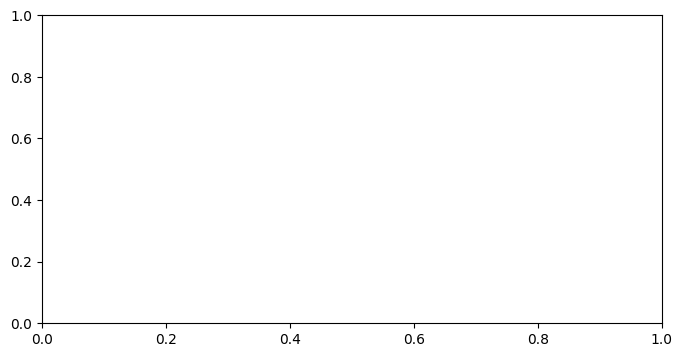

In [35]:
import matplotlib.pyplot as plt

# Datos de recompensa promedio a lo largo de los episodios
episodios_ajustados = list(range(1, 100))

recompensas_promedio = recompensa_episodios

# Crear la gráfica
plt.figure(figsize=(8,4))
plt.plot(episodios_ajustados, recompensas_promedio, label='Recompensa Promedio', color='blue')

# Añadir etiquetas y título
plt.xlabel('Episodios (Intervalos de 1000)')
plt.ylabel('Recompensa Promedio')
plt.title('Evolución de la Recompensa Promedio por Intervalos de 1000 Episodios')
plt.legend()
plt.grid(True)
plt.tight_layout()


# Mostrar la gráfica
plt.show()

## Análisis de casos (Éxitos y Fallos)

In [34]:
# Función para reproducir un episodio específico
def reproducir_episodio(agente, episodio, semilla, max_iteraciones=500):
    entorno = gym.make('LunarLander-v2', render_mode='human').env
    entorno.reset(seed=semilla)
    iteraciones = 0
    termino = False
    truncado = False
    estado_anterior, info = entorno.reset(seed=semilla)
    while iteraciones < max_iteraciones and not termino and not truncado:
        accion = episodio[iteraciones][1]
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        entorno.render()
        estado_anterior = estado_siguiente
        iteraciones += 1
    entorno.close()

### Reproducir episodios exitosos y no exitosos de los casos de prueba

In [32]:
# Reproducir un episodio específico
episodio_especifico = 31  # Cambia este valor al episodio que quieras reproducir
if episodio_especifico < len(episodios_exitosos):
    reproducir_episodio(agente, episodios_exitosos[episodio_especifico], semillas_exitosas[episodio_especifico])
else:
    print(f"No hay suficientes episodios exitosos para reproducir el episodio {episodio_especifico}")

In [31]:
# Reproducir un episodio específico
episodio_especifico = 203  # Cambia este valor al episodio que quieras reproducir
if episodio_especifico < len(episodios_no_exitosos):
    reproducir_episodio(agente, episodios_no_exitosos[episodio_especifico], semillas_exitosas[episodio_especifico])
else:
    print(f"No hay suficientes episodios no exitosos para reproducir el episodio {episodio_especifico}")

### Episodios Exitosos y no exitosos

La indeterminación del entorno en el problema del Lunar Lander proviene de la discretización de los estados. Dado que un mismo estado discretizado puede llevar a diferentes resultados debido a pequeñas variaciones que no se capturan en la discretización, el comportamiento del agente no siempre es predecible. El agente ha logrado aprender y adaptarse de manera efectiva en un (porcentaje) de los 1,000 episodios de prueba.

1. Episodios Exitosos
En los casos exitosos, el agente ha demostrado un control eficiente del propulsor principal, asegurándose de que la nave nunca descienda a una velocidad demasiado alta. Este control es fundamental para permitir que el agente pueda ajustar su orientación horizontal hacia la zona de aterrizaje. Desde el inicio, el agente toma decisiones que mantienen un equilibrio entre el uso del propulsor principal y los propulsores laterales, lo que le permite encadenar acciones efectivas que lo llevan a una recompensa exitosa.

Un patrón clave en los episodios exitosos es que, al evitar el uso excesivo de los propulsores laterales en momentos inadecuados, el agente es capaz de mantener una trayectoria controlada hacia la meta. Esto es particularmente importante en las primeras etapas del episodio, donde las decisiones erróneas tienen un mayor impacto negativo en el aterrizaje. Al ejecutar correctamente los propulsores en los momentos críticos, el agente asegura un aterrizaje seguro y controlado.

En cuanto a los episodios que no son exitosos podemos ver que una mala decision de propulsarse hacia un costado, siempre se vuelve muy dificil de corregir para el agente no pudiendo controlar su velocidad y saliendose del entorno dando un caso fallido teniendo tambien la variable de poder girar en su eje complejizando mas su recuperacion al "camino" correcto.

Vemos en otros tantos episodios, que el agente se propulsa hacia arriba por demas, al comienzo de su ejecucion, y creemos que al "salirse" del entorno el caso ya se considera como fallido.

Concluimos que la determinacion del exito del episodio, se basa mucho en las primeras decisiones que toma, dado a la sensibilidad que tienen las decisiones desde un comienzo y su poca habilidad de recuperacion ante malas decisiones.

2. Episodios No Exitosos

En los episodios fallidos, observamos que el principal factor que contribuye al fracaso es una decisión incorrecta de propulsarse hacia un costado al comienzo del episodio. Cuando el agente toma una mala decision al comienzo en este caso, propulsarse hacia un lado, pierde el control de la velocidad o de la orientación, lo que hace que sea muy difícil corregir la trayectoria posteriormente. En estos casos, el agente no logra reducir su velocidad o ajustar su orientación a tiempo, y termina saliéndose del entorno, lo que resulta en un episodio fallido.

Otro patrón común en los episodios no exitosos es el uso excesivo del propulsor principal al inicio del episodio. Esto genera que la nave se desplace demasiado hacia arriba, y al "salirse" del entorno, esto sucede al principio también ya que la nave esta cerca del "borde superior" lo que causaria que una mala decision de propulsarse por demás al comienzo lo llevaria a fallar.

3. Conclusiones sobre el Éxito y el Fracaso
Podemos concluir que el éxito de un episodio está altamente influenciado por las primeras decisiones que toma el agente. Dado el alto nivel de sensibilidad del entorno a las acciones iniciales, una mala decisión al inicio del episodio puede llevar a una situación difícil de corregir. Parte de este problema radica en la limitación del agente a poder prender mas de un propulsor a la vez, asi como tambien la limitacion de tomar un espacio discretizado para la decisiones.

La clave del éxito radica en que el agente logre encadenar un conjunto de decisiones correctas desde el principio, evitando movimientos innecesarios y ajustando cuidadosamente el uso de los propulsores. Cuando esto ocurre, el agente tiene una alta probabilidad de realizar un aterrizaje exitoso, minimizando las penalizaciones y maximizando las recompensas.

## Limitantes del agente

In [17]:
# Analizar los resultados aqui
